<table>
  <tr>
    <td><img src="logos/CSTB_logo.jpg" width="200" />
    <td><img src="logos/Heliocity_logo.png" width="200" /> 
    <td><img src="logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

Introduction / Context blabla

In [1]:
# import packages
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.optimize import curve_fit
from pvlib.temperature import  pvsyst_cell
from pvlib.pvsystem import pvwatts_dc 

# Change the directory path to import functions from local modules
if not 'workbookDir' in globals():
    workbookDir = Path(os.getcwd()).parent
print('Work directory: ' + str(workbookDir))
os.chdir(workbookDir)

from src.config import ROOT # Directory ROOT path
from src.utils.helio_fmt import setup_helio_plt 
from src.utils.vizualization_tools import cldr_heatmap
setup_helio_plt() # set plot format and font

Work directory: C:\Users\MATHIEU\OneDrive - CSTBGroup\Bureau\Code\datasun_fault_detection


# I. Data visualization

## Satellite weather data

In [3]:
index = pd.date_range("20190801", "20191101", freq="15min", tz="CET")

# Load satellite weather data: incident irradiation, direct irradiation, temperature, wind
weather_data = pd.read_csv(ROOT / "data" / "meteo_sample.csv", index_col=0) 

weather_data["temp_air"] = weather_data["temp_air"] - 273.15
weather_data.index = pd.to_datetime(weather_data.index)
weather_data = weather_data.reindex(index)
weather_data.dropna().head()

poa_global  poa_diffuse  ghi  ghi_c  temp_air  \
2019-08-01 02:00:00+02:00         0.0          0.0  0.0    0.0     17.24   
2019-08-01 02:15:00+02:00         0.0          0.0  0.0    0.0     17.09   
2019-08-01 02:30:00+02:00         0.0          0.0  0.0    0.0     16.93   
2019-08-01 02:45:00+02:00         0.0          0.0  0.0    0.0     16.79   
2019-08-01 03:00:00+02:00         0.0          0.0  0.0    0.0     16.67   

                           wind_speed  rain_fall  
2019-08-01 02:00:00+02:00        2.09        0.0  
2019-08-01 02:15:00+02:00        2.10        0.0  
2019-08-01 02:30:00+02:00        2.10        0.0  
2019-08-01 02:45:00+02:00        2.11        0.0  
2019-08-01 03:00:00+02:00        2.11        0.0

Following the naming convention from pvlib: https://pvlib-python.readthedocs.io/en/stable/user_guide/variables_style_rules.html#variables-style-rules

- **poa_global**: global irradiation in plane. sum of diffuse and beam projection [W/m2]
- **poa_diffuse**: total diffuse irradiation in plane. sum of ground and sky diffuse [W/m2]
- **ghi**: global horizontal irradiance [W/m2]
- **ghi_c**: Clear-sky global horizontal irradiance [W/m2]
- **temp_air**: temperature of the air, for this workshop [°C]
- **wind_speed**: wind speed [m/s]
- **rain_fall**: rain fall [mm]

<IPython.core.display.Javascript object>


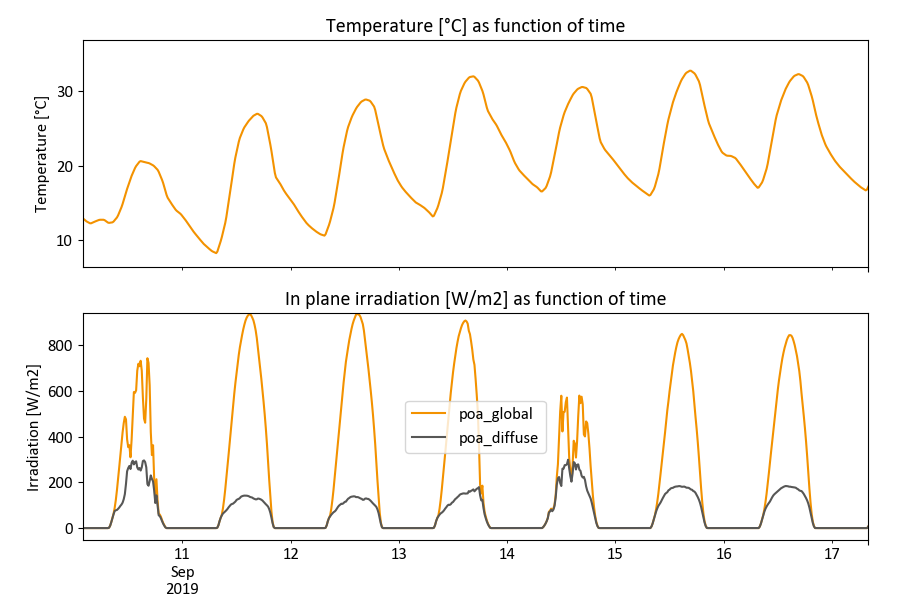

In [100]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True)
weather_data["temp_air"].plot(ax=ax1, title="Temperature [°C] as function of time",ylabel="Temperature [°C]")
meteo_plot = weather_data[["poa_global","poa_diffuse"]]
meteo_plot.plot(ax=ax2, title="In plane irradiation [W/m2] as function of time",ylabel="Irradiation [W/m2]")
plt.tight_layout()


## PV electric data

The installation is comprised of modules strings in parallel.

Each string is comprised of 21 modules.

In [101]:
# Load  pv data
pv_data = pd.read_csv(ROOT / "data" / "pv_data_sample.csv", index_col=0) # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data["Pdc"] = pv_data["Vdc"] * pv_data["Idc"] # Calculates DC power Pdc
pv_data.index = pd.to_datetime(pv_data.index)
pv_data = pv_data.reindex(index)
pv_data.dropna().head()

Vdc   Idc    Pac          Pdc
2019-08-01 06:45:00+02:00  519.0  0.07    0.0    36.330000
2019-08-01 07:00:00+02:00  580.0  0.04    1.0    23.199999
2019-08-01 07:15:00+02:00  583.0  0.32   15.0   186.559996
2019-08-01 07:30:00+02:00  485.0  1.48  244.0   717.800009
2019-08-01 07:45:00+02:00  555.0  2.31  734.0  1282.049968

<IPython.core.display.Javascript object>


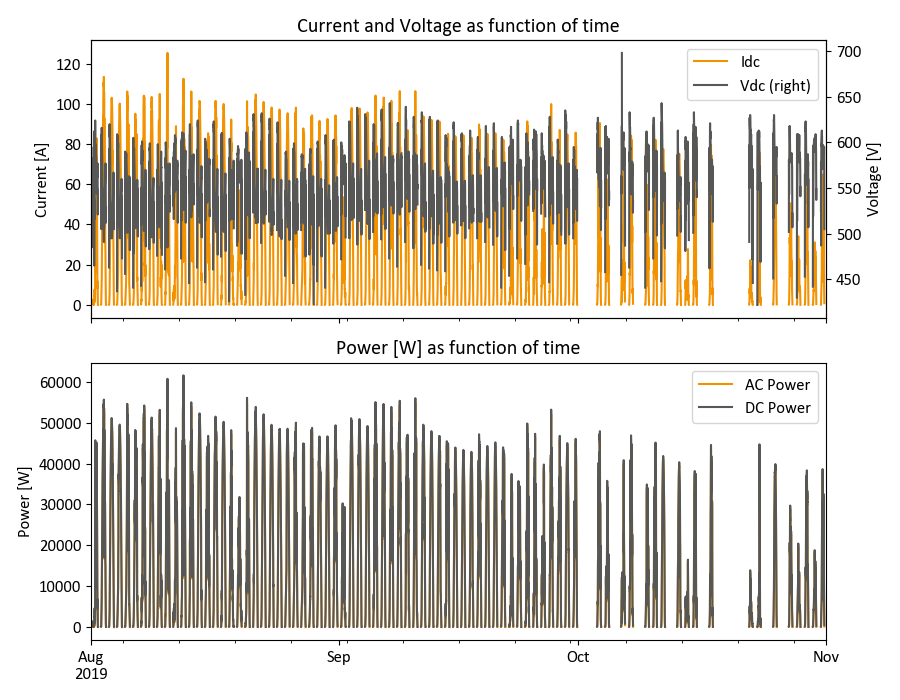

In [102]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data["Idc"].plot(ax=ax1, title="Current and Voltage as function of time", ylabel="Current [A]", legend=True)
pv_data["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time", ylabel="Power [W]")
plt.tight_layout()

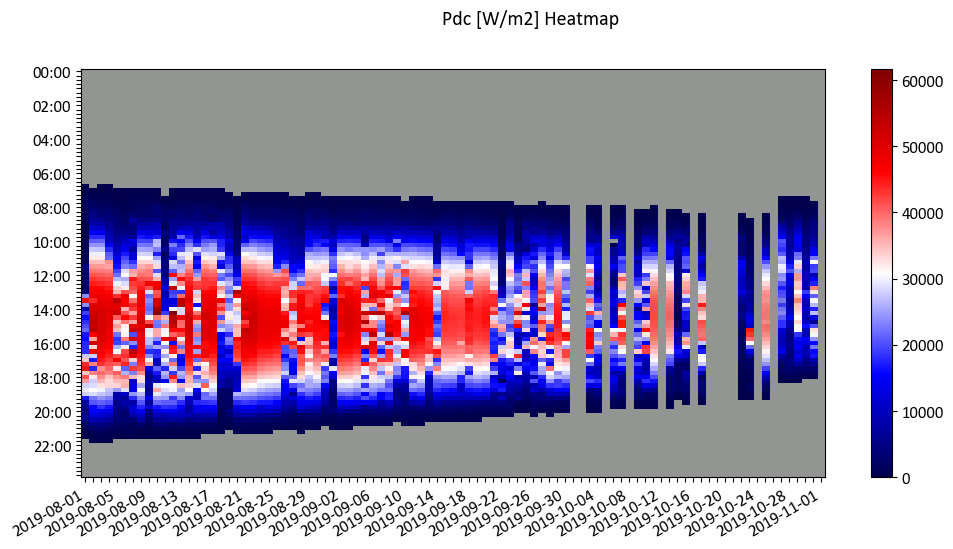

In [7]:
%matplotlib inline
_ = cldr_heatmap(pv_data, "Pdc", figure_title="Pdc [W/m2] Heatmap")

# II. Power model fit

Modeling the power of an installation goes into two steps:

1. Modeling the module cell temperature
2. Modeling the installation power (requiring the cell temperature as input)

## A. Cell temperature model

<IPython.core.display.Javascript object>


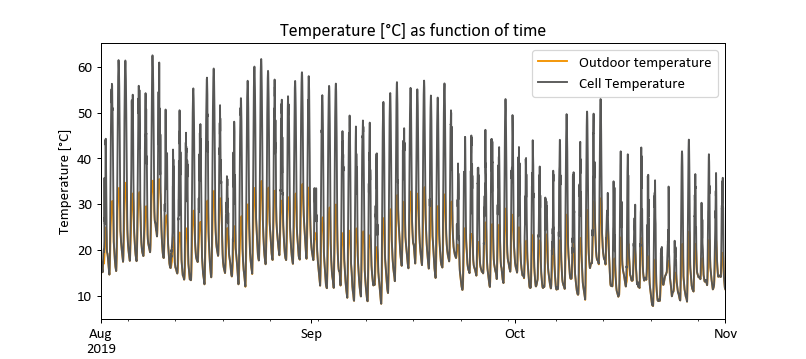

<AxesSubplot: title={'center': 'Temperature [°C] as function of time'}, ylabel='Temperature [°C]'>

In [8]:
%matplotlib notebook
# Approximates cell temperature thanks to pvsyst model (implemented in pvlib) 

u_c = 29  # Assumption: freestanding
u_v = 0  # No subject to wind cooling effect
temp_cell = pvsyst_cell(weather_data["poa_global"], weather_data["temp_air"], u_c=u_c, u_v=u_v)
    
fig, ax = plt.subplots(1, 1, figsize=(9,4), sharex=True)
weather_data["temp_air"].to_frame("Outdoor temperature").plot(ax=ax, title="Temperature [°C] as function of time",ylabel="Temperature [°C]")
temp_cell.to_frame("Cell Temperature").plot(ax=ax)

## B. Pdc power model

### PvWatt model fit

In [9]:
# Empirically fit with brute force pvwatt power model (implemented in pvlib) 
def func_to_fit(X, pdc0, gamma_pdc):
    g_poa_effective, temp_cell = X    
    pdc = pvwatts_dc(g_poa_effective, temp_cell, pdc0, gamma_pdc, temp_ref=25.0)
    return pdc 

# Filter all inputs on august 2019 (most stable period of the dataset) to fit the model
august_index = (pv_data.index > '2019-08-01 00:00:00+02:00') & (pv_data.index > '2019-08-01 00:00:00+02:00')
index_fit = pv_data.loc[august_index, "Pdc"].dropna().index
pdc_fit = pv_data["Pdc"].reindex(index_fit)
g_poa_effective_fit = weather_data["poa_global"].reindex(index_fit)  # Roughly assume g_poa_effective is equal to poa_global
temp_cell_fit = temp_cell.reindex(index_fit)

# Fit with initial guesses for pvwatt model parameters: P0 and gamma
p0 = (40000., -0.002)
pdc0, gamma_pdc = curve_fit(func_to_fit, (g_poa_effective_fit, temp_cell_fit), pdc_fit, p0)[0]

# Estimating Pdc from satellite data (irradiation and cell temperature coming from ambient temperature & irradiation)
pdc_estimated = pvwatts_dc(weather_data["poa_global"], temp_cell, pdc0, gamma_pdc, temp_ref=25.0)

### PvWatt model accuracy exploration

In [10]:
error = (pdc_estimated - pv_data["Pdc"])
error_mean= error.abs().sum() / pv_data["Pdc"].abs().sum()
print(f"The average error of the model is {round(error_mean * 100, 2)}%")

The average error of the model is 14.4%


<IPython.core.display.Javascript object>


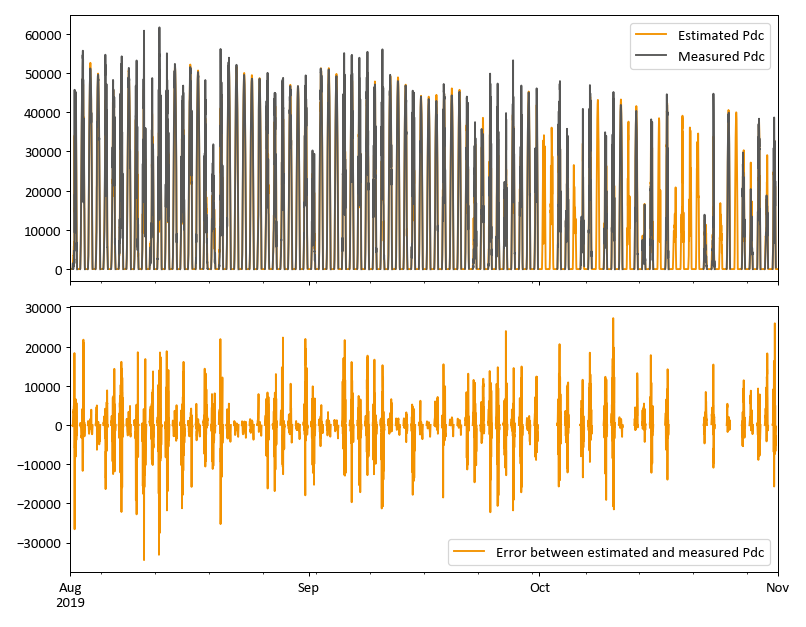

In [11]:
%matplotlib notebook


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pdc_estimated.to_frame("Estimated Pdc").plot(ax=ax1)
pv_data["Pdc"].to_frame("Measured Pdc").plot(ax=ax1)
error.to_frame("Error between estimated and measured Pdc").plot(ax=ax2)

plt.tight_layout()

The more cloudy it is, the less accurate the model is


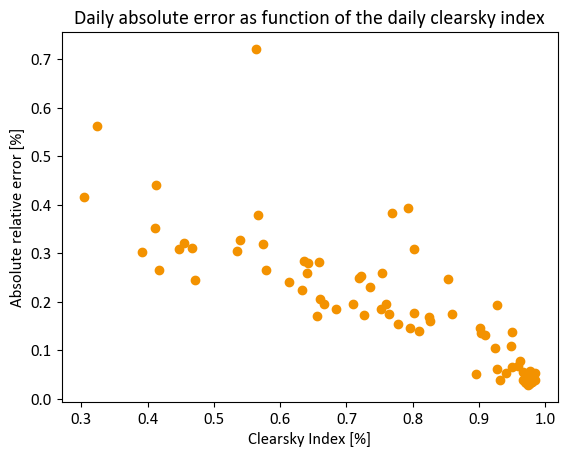

In [12]:
%matplotlib inline

clearsky_daily = weather_data["ghi"].resample("D").sum() / weather_data["ghi_c"].resample("D").sum()
error_daily = (error.abs().resample("D").sum() / pv_data["Pdc"].resample("D").sum()).clip(lower=-1,upper=1)


plt.plot(clearsky_daily, error_daily, linewidth=0, marker="o")
plt.title("Daily absolute error as function of the daily clearsky index")
plt.ylabel("Absolute relative error [%]")
plt.xlabel("Clearsky Index [%]")
print("The more cloudy it is, the less accurate the model is")

Satellite data, on which the power model is based, have troubles to reflect real conditions on cloudy days 

I-V , P in red
Idea of putting the waterfall chart from Heliocity
temperature model: https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/temperature.html
pvlib_model: https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html

spot outliers: https://pvanalytics.readthedocs.io/en/stable/generated/gallery/index.html
shading detection: https://reader.elsevier.com/reader/sd/pii/S0038092X20311373?token=D7CB0D137A9119B16791064479490D2319C77C70C36C61ABDE26FB880D5CC65C8BADA897B861A9D483332E810D7BD608&originRegion=eu-west-1&originCreation=20221020154121

# III. Fault detection

## A. Shading

A fixed-rectangular shading obstructs the irradiation to the PV installation.

One solution includes the latitude and longitude as input: roughly (48,3)

<IPython.core.display.Javascript object>


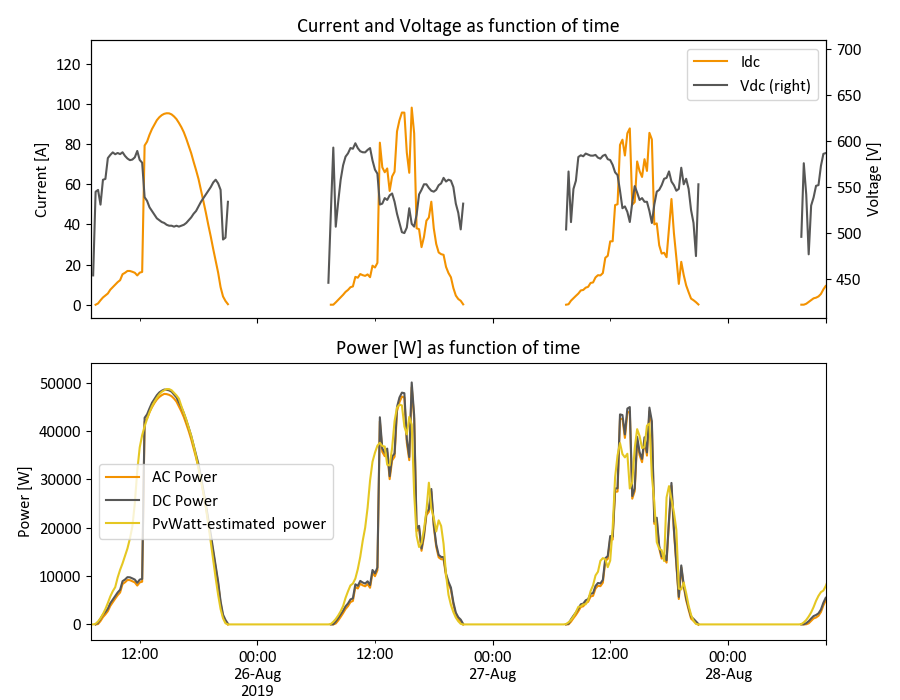

In [103]:
pv_data_shading = pd.read_csv(ROOT / "data" / "pv_data_shading.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_shading.index = pd.to_datetime(pv_data_shading.index)
pv_data_shading = pv_data_shading.reindex(index)

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_shading["Idc"].plot(ax=ax1, title="Current and Voltage as function of time", ylabel="Current [A]", legend=True)
pv_data_shading["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_shading[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

#### Solution 1

In [14]:
def shading_detection(pdc: pd.Series,
                      pdc_estimated: pd.Series,
                      gi: pd.Series,
                      gid: pd.Series,
                      error_rel_thresh: float = 0,
                      error_window_thresh: float = 0.5,
                      gi_gid_ratio_thresh: float = 0.5,
                      window: str = "31D") -> pd.Series:
    """
    Flag shading according to the relative error from an estimated.
    Recurrent and ponctual relative errors are assessed.
    The algorithm has troubles to detect error on low irradiance.

    :param pdc: DC power [W/m2]
    :param pdc_estimated: Estimated DC power [W/m2]
    :param window: number of days to evaluate the recurrent pattern (center-window)

    :return: boolean pd.Series with flags when shading is detected
    """
    error = ((pdc_estimated - pdc) / pdc.abs()).clip(lower=-5, upper=5).to_frame("error_rel")
    error["time"] = error.index.time
    error["shading_flag"] = False
    error["gid_gi_ratio"] = gi / gid
    error["benchmark"] = np.nan

    for time in error["time"].unique():
        error_time = error[error["time"] == time].copy()
        if not error_time.empty:
            error.loc[error_time.index, "benchmark"] = \
                error_time["error_rel"].rolling(window, center=True).mean(min_count=1)

    error["shading_flag"] = (error["error_rel"] > error_rel_thresh) & \
                            (error["benchmark"] > error_window_thresh) & \
                            (error["error_rel"] > error["gid_gi_ratio"] * gi_gid_ratio_thresh)

    return error["shading_flag"]


In [15]:
shading_flags = shading_detection(pv_data_shading["Pdc"], pdc_estimated, weather_data["poa_global"], weather_data["poa_diffuse"], 
                                  error_rel_thresh=0.1, error_window_thresh=0.5,  gi_gid_ratio_thresh=0.3)

<IPython.core.display.Javascript object>


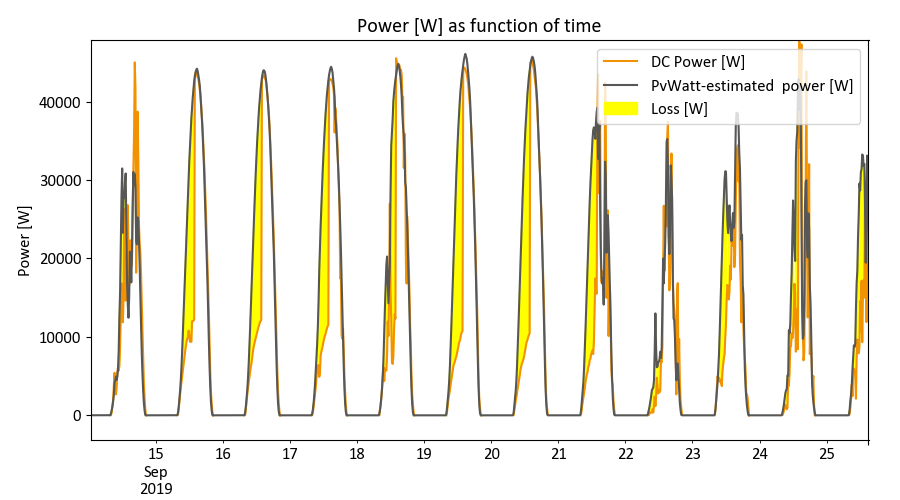

In [104]:
# Dataframe built for plotting purpose
shading_loss = pd.DataFrame(index=pv_data_shading.index, columns=["Pdc","Pdc_estimated","loss","shading"], data=0)
shading_loss["shading"] = False
shading_loss.loc[shading_flags, "shading"] = shading_flags
shading_loss.loc[:,"Pdc"] = pv_data_shading.loc[shading_flags, "Pdc"]
shading_loss.loc[:,"Pdc_estimated"] = pdc_estimated[shading_flags]
shading_loss["loss"] = shading_loss["Pdc_estimated"]  - shading_loss["Pdc"] 

%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(9,5))
pv_data_shading["Pdc"].to_frame("DC Power [W]").plot(ax=ax, title="Power [W] as function of time", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power [W]").plot(ax=ax, title="Power [W] as function of time", ylabel="Power [W]")
plt.fill_between(shading_loss.index, shading_loss["Pdc"], shading_loss["Pdc_estimated"], color="yellow", label="Loss [W]")
plt.legend()
plt.tight_layout()

In [17]:
shading_loss_perc = shading_loss["loss"].sum() / pdc_estimated.sum()
print(f"Shading induces {round(shading_loss_perc*100, 2)}% of losses")

Shading induces 16.5% of losses


#### Solution 2

In [18]:
from sklearn.cluster import KMeans
from pvlib.solarposition import get_solarposition

def error_cluster(pdc: pd.Series,
                  pdc_estimated: pd.Series,
                  latitude: float = 48,
                  longitude: float = 3,
                  n_cluster=2) -> pd.DataFrame:
    """
    Return KNN-Cluster based on azimuth, elevation and error
    
    :param pdc: Real DC power timeserie (including shading)
    :param pdc_estimated: Estiamted DC power timeseries (without shading)
    :param latitude: Latitude of the site
    :param longitude: Longitude of the site
    :param n_cluster: Number of cluster to return
    
    :return: pd.Dataframe with cluster number in  "class" column
    """
    error = ((pdc_estimated - pdc) / pdc.abs()).clip(lower=-5, upper=5).to_frame("error_rel")
    solar_pos = get_solarposition(pdc.index, latitude, longitude, None)
    error["azimuth"] = solar_pos["azimuth"]
    error["elevation"] = solar_pos["elevation"] 

    # normalization
    error_fit = error.dropna().copy()
    for col in error_fit.columns:
        error_fit[col] = (error_fit[col] - error_fit[col].mean()) / error_fit[col].std()
    mod = KMeans(n_clusters=n_cluster).fit(error_fit)
    error_class = pd.Series(mod.predict(error_fit), index=error_fit.index)

    error["class"] = error_class

    return error

Text(0.5, 1.0, 'KNN-error class as function of azimuth and elevation')

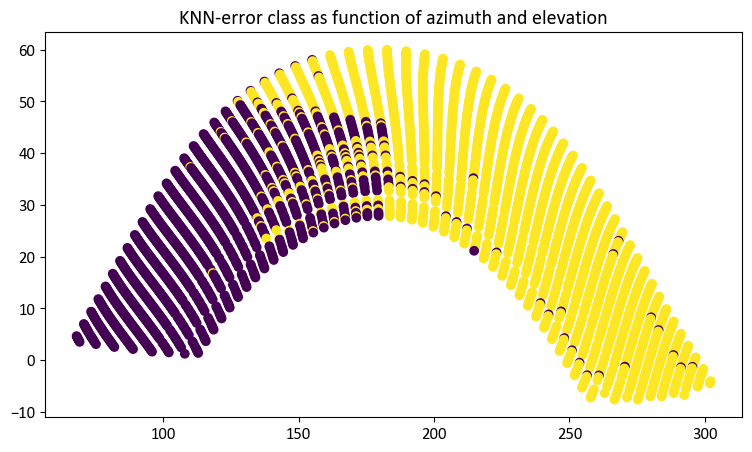

In [19]:
error = error_cluster(pv_data_shading["Pdc"], pdc_estimated, latitude=48, longitude=3)

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(9,5))
plt.scatter(error["azimuth"], error["elevation"], c=error["class"])
plt.title("KNN-error class as function of azimuth and elevation")

## B. Clipping

<IPython.core.display.Javascript object>


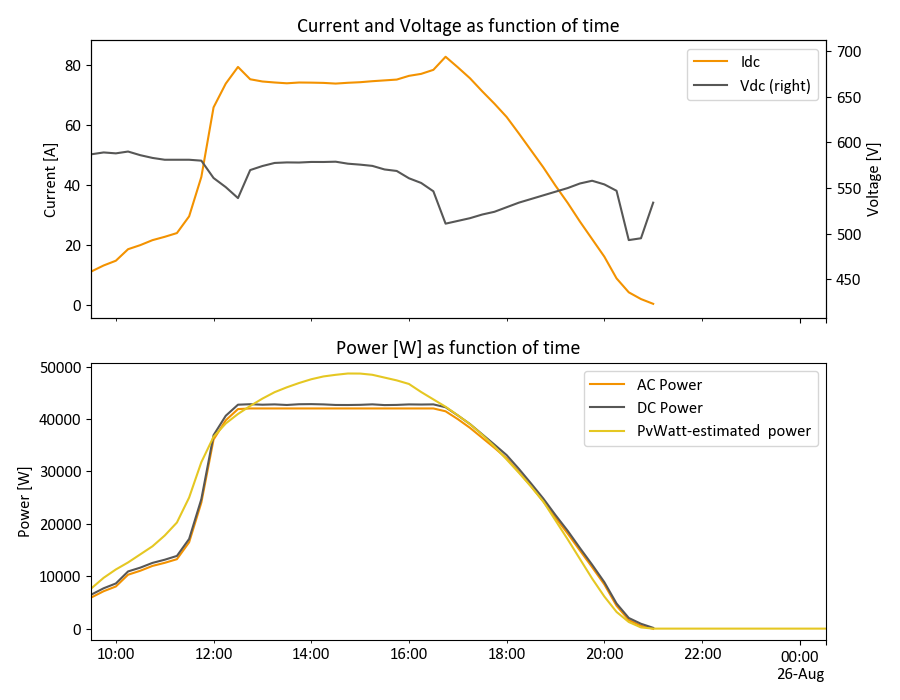

In [105]:
pv_data_clipping = pd.read_csv(ROOT / "data" / "pv_data_clipping.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_clipping.index = pd.to_datetime(pv_data_clipping.index)
pv_data_clipping = pv_data_clipping.reindex(index)

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_clipping["Idc"].plot(ax=ax1, title="Current and Voltage as function of time", ylabel="Current [A]", legend=True)
pv_data_clipping["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_clipping[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

#### Solution

In [21]:
from pvanalytics.features.clipping import threshold
clipping_flags = threshold(pv_data_clipping["Pac"])
clipping_flags = clipping_flags & (pdc_estimated > pv_data_clipping["Pdc"])

<IPython.core.display.Javascript object>


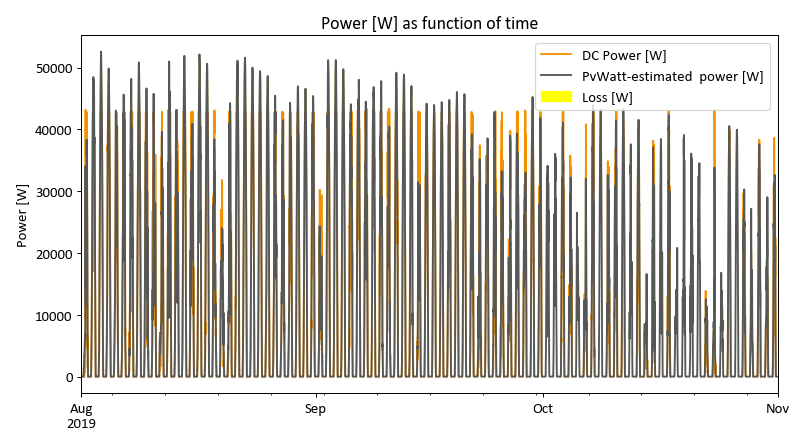

In [88]:
# Dataframe built for plotting purpose
def clipping_loss_calc(pv_data_clipping, pdc_estimated, clipping_flags):
    clipping_loss = pd.DataFrame(index=pv_data_clipping.index, columns=["Pdc","Pdc_estimated","loss","clipping"], data=0)
    clipping_loss["clipping"] = False
    clipping_loss.loc[clipping_flags, "clipping"] = clipping_flags
    clipping_loss.loc[:,"Pdc"] = pv_data_clipping.loc[clipping_flags, "Pdc"]
    clipping_loss.loc[:,"Pdc_estimated"] = pdc_estimated[clipping_flags]
    clipping_loss["loss"] = clipping_loss["Pdc_estimated"]  - clipping_loss["Pdc"] 
    return clipping_loss

clipping_loss = clipping_loss_calc(pv_data_clipping, pdc_estimated, clipping_flags)

%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(9,5))
pv_data_clipping["Pdc"].to_frame("DC Power [W]").plot(ax=ax, title="Power [W] as function of time", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power [W]").plot(ax=ax, title="Power [W] as function of time", ylabel="Power [W]")
plt.fill_between(clipping_loss.index, clipping_loss["Pdc"], clipping_loss["Pdc_estimated"], color="yellow", label="Loss [W]")
plt.legend()
plt.tight_layout()

In [23]:
clipping_loss_perc = clipping_loss["loss"].sum() / pdc_estimated.sum()
print(f"Clippiing induces {round(clipping_loss_perc*100, 2)}% of losses")

Clippiing induces 1.83% of losses


## C. Module short_circuit

Each string is comprised of 21 modules.

<IPython.core.display.Javascript object>


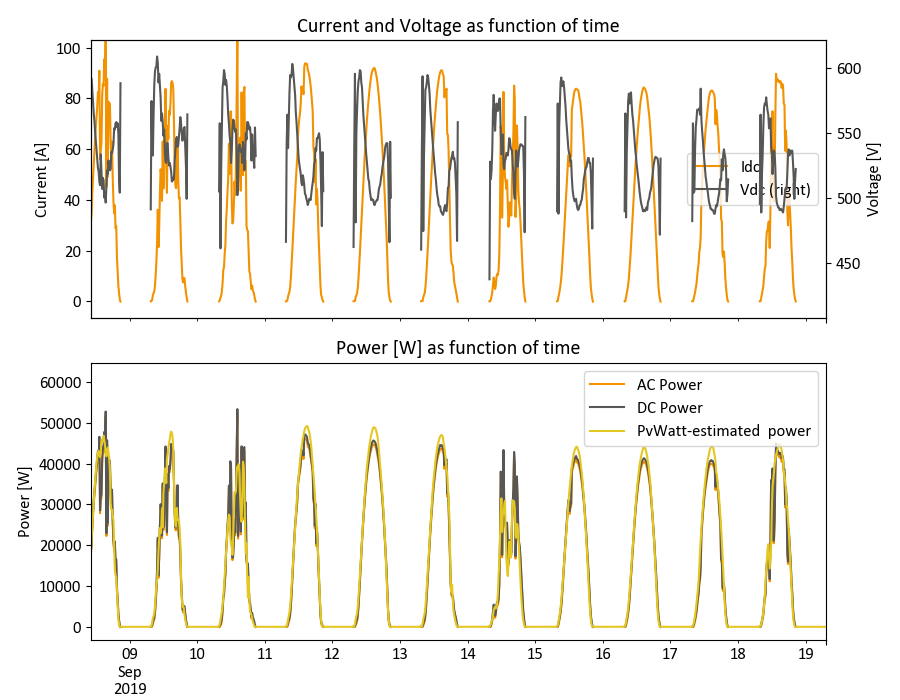

In [106]:
pv_data_shortcircuit = pd.read_csv(ROOT / "data" / "pv_data_shortcircuit.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_shortcircuit.index = pd.to_datetime(pv_data_shortcircuit.index)
pv_data_shortcircuit = pv_data_shortcircuit.reindex(index)

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_shortcircuit["Idc"].plot(ax=ax1, title="Current and Voltage as function of time", ylabel="Current [A]", legend=True)
pv_data_shortcircuit["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_shortcircuit[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

#### Solution

In [34]:
def vmp_king(goa_effective: pd.Series, temp_cell: pd.Series,
             c2: float, c3: float, beta: float, vmp_ref: float,
             temp_stc: float = 25):
    """
    Model Vmp according to King's proposition.
    Ref: King, D & Kratochvil, J & Boyson, W. (2004). Photovoltaic Array Performance Model. 8. 10.2172/919131.
    """
    temp_cell_K = temp_cell + 273.15
    vmp = vmp_ref + \
          c2 * temp_cell_K * np.log(goa_effective / 1000) + \
          c3 * (temp_cell_K * np.log(goa_effective) / 1000) ** 2 + \
          beta * goa_effective * (temp_cell - temp_stc)

    return vmp


def fit_vmp_king(g_poa_effective: pd.Series, temp_cell: pd.Series, vmp: pd.Series,
                 c2: float = 1, c3: float = -1, beta: float = -1, vmp_ref: float = 100):
    """Empirically fit Vmp King model's parameters"""

    # initial guesses
    p0_vmp = (c2, c3, beta, vmp_ref)

    # Make sure there is no Nans and no vmp & irradiation with 0s
    index_fit = vmp.dropna().index.intersection(g_poa_effective.dropna().index).intersection(temp_cell.dropna().index)
    index_fit = vmp.reindex(index_fit)[vmp.reindex(index_fit) != 0].index
    index_fit = g_poa_effective.reindex(index_fit)[g_poa_effective.reindex(index_fit) != 0].index
    vmp_fit = vmp.reindex(index_fit)
    g_poa_effective_fit = g_poa_effective.reindex(index_fit)
    temp_cell_fit = temp_cell.reindex(index_fit)

    # Fit vmp model
    def vmp_to_fit(X, c2, c3, beta, vmp_ref):
        g_poa_effective, temp_cell = X
        return vmp_king(g_poa_effective, temp_cell, c2, c3, beta, vmp_ref)

    c2, c3, beta, vmp_ref = curve_fit(vmp_to_fit, (g_poa_effective_fit, temp_cell_fit), (vmp_fit), p0_vmp)[0]

    return (c2, c3, beta, vmp_ref)


(c2, c3, beta, vmp_ref) = fit_vmp_king(weather_data["poa_global"], temp_cell=temp_cell, vmp=pv_data["Vdc"])
vdc_estimated = vmp_king(weather_data["poa_global"], temp_cell, c2, c3, beta, vmp_ref)

<IPython.core.display.Javascript object>


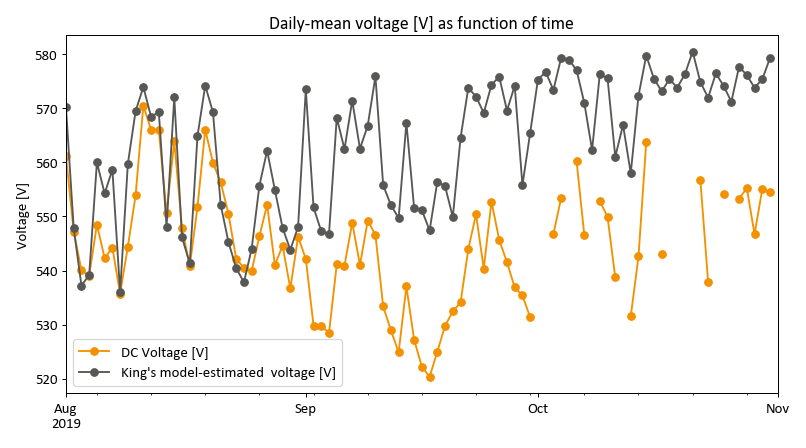

In [53]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(9,5))
pv_data_shortcircuit["Vdc"].resample("D").mean().to_frame("DC Voltage [V]").plot(ax=ax, title="Daily-mean voltage [V] as function of time", ylabel="Voltage [V]", marker="o")
vdc_estimated.resample("D").mean().to_frame("King's model-estimated  voltage [V]").plot(ax=ax, ylabel="Voltage [V]", marker="o")
plt.tight_layout()

In [54]:
def shut_module_detection(vdc: pd.Series,
                          vdc_estimated: pd.Series,
                          threshold: float = -20,
                          window: str = "21D"):
    diff = vdc_estimated.resample("D").mean() - vdc.resample("D").mean()
    diff.index = diff.index.date
    df = pd.Series(index=diff.index, dtype=float)
    for date in np.unique(diff.index):
        date_previous = date - pd.Timedelta(window)
        date_after = date + pd.Timedelta(window)
        df.loc[date] = diff.loc[(diff.index < date) & (diff.index >= date_previous)].mean(skipna=True) - \
                       diff.loc[(diff.index < date_after) & (diff.index >= date)].mean(skipna=True)

    flags_sc = (df < threshold)

    return flags_sc, df

threshold = - pv_data["Vdc"].median() * 1 / 21 * 70 / 100
flags_sc, df = shut_module_detection(pv_data_shortcircuit["Vdc"], vdc_estimated, threshold)

datetime.date(2019, 9, 1)

<IPython.core.display.Javascript object>


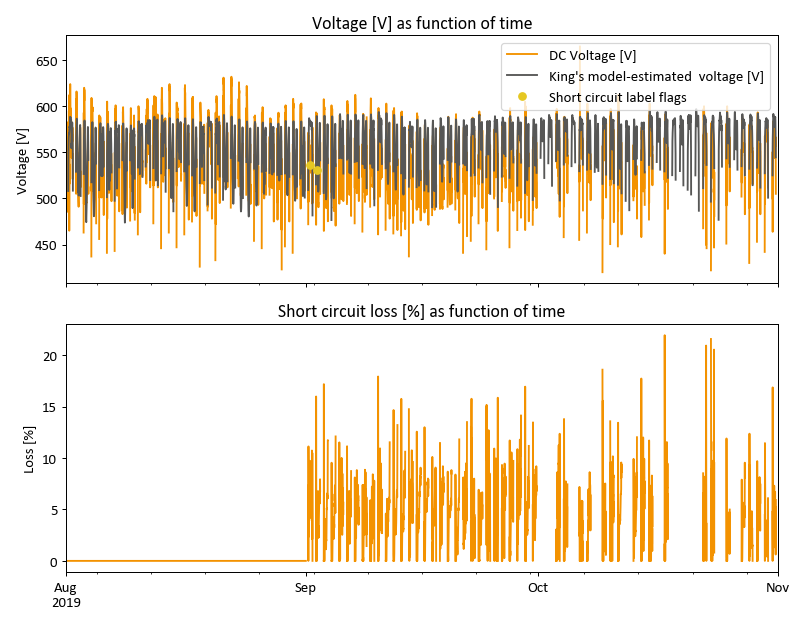

In [97]:
flags_plot = flags_sc.copy()
flags_plot.index = pd.to_datetime(flags_plot.index).tz_localize("CET") + pd.Timedelta(hours=12)
flags_plot = flags_plot.reindex(pv_data_shortcircuit.index)
flags_plot[flags_plot.isna()] = False
sc_date = pd.to_datetime(flags_sc[flags_sc].idxmin()).tz_localize("CET")

# Loss dataframe
shortcircuit_loss = pd.DataFrame(index=pv_data_clipping.index, columns=["Vdc","Vdc_estimated","loss_perc","shortcircuit"], data=0)
shortcircuit_loss["shortcircuit"] = False
shortcircuit_loss.loc[shortcircuit_loss.index > sc_date, "shortcircuit"] = True
shortcircuit_loss.loc[:,"Vdc"] = pv_data_shortcircuit["Vdc"]
shortcircuit_loss.loc[:,"Vdc_estimated"] = vdc_estimated
shortcircuit_loss["loss_perc"] = ((vdc_estimated - pv_data_shortcircuit["Vdc"]) / vdc_estimated * 100).clip(lower=0)
shortcircuit_loss.loc[~shortcircuit_loss["shortcircuit"], "loss_perc"] = 0

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_shortcircuit["Vdc"].to_frame("DC Voltage [V]").plot(ax=ax1, title="Voltage [V] as function of time", ylabel="Voltage [V]")
vdc_estimated.to_frame("King's model-estimated  voltage [V]").plot(ax=ax1, ylabel="Voltage [V]")
pv_data_shortcircuit.loc[flags_plot, "Vdc"].to_frame("Short circuit label flags").reindex(pv_data_clipping.index).plot(ax=ax1, marker="o", linewidth=0)
shortcircuit_loss["loss_perc"].plot(ax=ax2, title="Short circuit loss [%] as function of time", ylabel="Loss [%]")
plt.tight_layout()

In [85]:
shortcircuit_loss_perc = (shortcircuit_loss["loss_perc"] * pdc_estimated).sum()/ pdc_estimated.sum()
print(f"Clipping induces {round(shortcircuit_loss_perc, 2)}% of losses")

Clipping induces 2.23% of losses


## D. All defauts combined

<IPython.core.display.Javascript object>


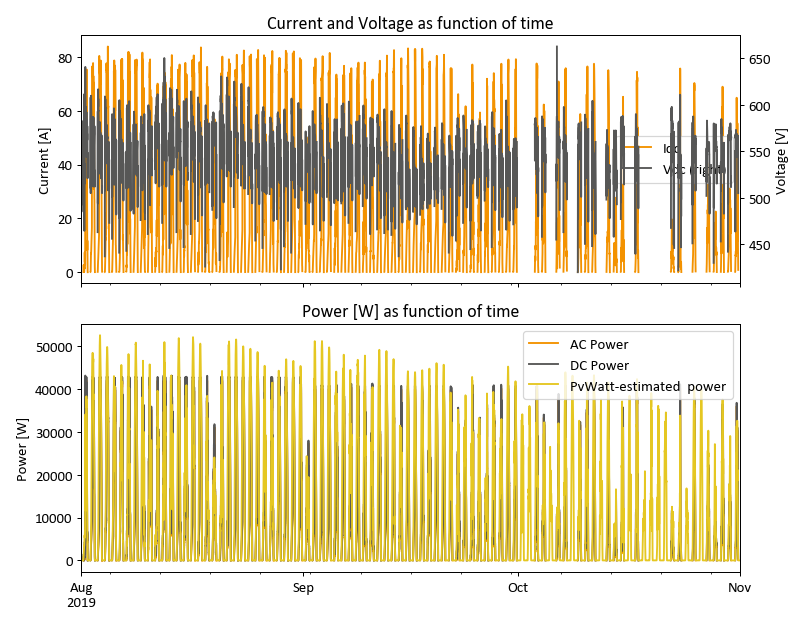

In [99]:
pv_data_all_defaults = pd.read_csv(ROOT / "data" / "pv_data_all_defaults.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_all_defaults.index = pd.to_datetime(pv_data_all_defaults.index)
pv_data_all_defaults = pv_data_all_defaults.reindex(index)

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_all_defaults["Idc"].plot(ax=ax1, title="Current and Voltage as function of time", ylabel="Current [A]", legend=True)
pv_data_all_defaults["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_all_defaults[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

In [91]:
pv_data_all_defaults["Pac"].dropna()

2019-08-01 07:00:00+02:00       2.709670
2019-08-01 07:15:00+02:00      14.617031
2019-08-01 07:30:00+02:00     261.253858
2019-08-01 07:45:00+02:00     781.970230
2019-08-01 08:00:00+02:00     964.777867
                                ...     
2019-10-31 17:00:00+01:00    8111.126708
2019-10-31 17:15:00+01:00    4841.055798
2019-10-31 17:30:00+01:00    2442.869200
2019-10-31 17:45:00+01:00     696.230634
2019-10-31 18:00:00+01:00      82.738549
Name: Pac, Length: 4174, dtype: float64

In [95]:
from pvanalytics.features.clipping import threshold
clipping_flags = threshold(pv_data_all_defaults["Pac"])
clipping_flags = clipping_flags & (pdc_estimated > pv_data_all_defaults["Pdc"])
clipping_loss = clipping_loss_calc(pv_data_all_defaults, pdc_estimated, clipping_flags)


In [96]:
from pvanalytics.features.clipping import threshold
clipping_flags = threshold(pv_data_all_defaults["Pac"])

clipping_loss_perc = clipping_loss["loss"].sum() / pdc_estimated.sum()
print(f"Clippiing induces {round(clipping_loss_perc*100, 2)}% of losses")

Clippiing induces 1.25% of losses
